# Exercise 11 Part 1: Self-Attention
**Summer Semester 2024**

**Author**: Stefan Baumann (stefan.baumann@lmu.de)

### Task: Implement Self-Attention
In this exercise, you will implement multi-head self-attention for a 2D sequence of tokens (shape `B D H W`) yourself using **only basic functions (no pre-made attention implementations!)**. You're allowed to use simple functions such as, e.g., `torch.bmm()`, `torch.nn.functional.softmax()`, ... and simple modules such as `torch.nn.Linear`.

Usage of functions provided by the `einops` library (such as `einops.rearrange()`) is also allowed and encouraged (but completely optional!), as it allows writing the code in a nice and concise way by specifying operations across axes of tensors as strings instead of relying on dimension indices.<br>
A short introduction into einops is available at https://nbviewer.org/github/arogozhnikov/einops/blob/master/docs/1-einops-basics.ipynb.

In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device "{device}".')

Using device "cuda".


In [2]:
class SelfAttention2d(nn.Module):
    def __init__(
        self,
        embed_dim: int = 256,
        head_dim: int = 32,
        value_dim: int = 32,
        num_heads: int = 8,
    ):
        """Multi-Head Self-Attention Module with 2d token input & output

        Args:
            embed_dim (int, optional): Dimension of the tokens at the input & output. Defaults to 256.
            head_dim (int, optional): Per-head dimension of query & key. Defaults to 32.
            value_dim (int, optional): Per-head dimension of values. Defaults to 32.
            num_heads (int, optional): Number of attention heads. Defaults to 6.
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.head_dim = head_dim
        self.value_dim = value_dim
        self.num_heads = num_heads

        self.q = nn.Linear(embed_dim, num_heads * head_dim, bias=False)
        self.k = nn.Linear(embed_dim, num_heads * head_dim, bias=False)
        self.v = nn.Linear(embed_dim, num_heads * value_dim, bias=False)
        self.out = nn.Linear(num_heads * value_dim, embed_dim, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward of multi-head self-attention

        Args:
            x (torch.Tensor): Input tensor of shape (B, D, H, W) (batch, embedding dimension, height, width)

        Returns:
            torch.Tensor: Output tensor of shape (B, D, H, W) (batch, embedding dimension, height, width)
        """
        B, D, H, W = x.shape
        # I need to keep the dimensions to not be confused with the shapes. That is why I wrote the comments like this.
        # (B, H*W, D)
        x = x.view(B, D, H * W).permute(0, 2, 1)  
        
        # (B, H*W, num_heads*head_dim)
        # torch.Size([4, 576, 256])
        Q = self.q(x)
        # torch.Size([4, 576, 256])
        K = self.k(x)
        # torch.Size([4, 576, 256])
        V = self.v(x)

        # (B, num_heads, H*W, head_dim)
        # head_dim*num_heads = 256
        Q = Q.view(B, H * W, self.num_heads, self.head_dim).permute(0, 2, 1, 3) 
        K = K.view(B, H * W, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  
        V = V.view(B, H * W, self.num_heads, self.value_dim).permute(0, 2, 1, 3) 

        attention = (Q @ K.transpose(-2, -1)) / math.sqrt(self.head_dim) 
        attention = F.softmax(attention, dim=-1)
        attention = attention @ V  
        attention = attention.permute(0, 2, 1, 3).reshape(B, H * W, self.num_heads * self.value_dim)  

        out = self.out(attention).permute(0, 2, 1).view(B, D, H, W) 
        return out

# Unit Test (single-head) DO NOT CHANGE!
with torch.no_grad():
    layer = SelfAttention2d(embed_dim=256, head_dim=256, value_dim=256, num_heads=1).to(device)
    x = torch.randn((4, 256, 24, 24), device=device)
    res_layer = layer(x)

    layer_ref = nn.MultiheadAttention(layer.embed_dim, layer.num_heads).to(device)
    layer_ref.load_state_dict({ 'in_proj_weight': torch.cat([layer.q.weight, layer.k.weight, layer.v.weight]), 'out_proj.weight': layer.out.weight }, strict=False)
    res_ref = layer_ref(*[x.view(*x.shape[:2], -1).permute(2, 0, 1)] * 3)[0].permute(1, 2, 0).view(*x.shape)
    assert torch.allclose(res_layer, res_ref, rtol=1e-2, atol=1e-5), 'Single-head attention result incorrect.'

# Unit Test (multi-head) DO NOT CHANGE!
with torch.no_grad():
    layer = SelfAttention2d().to(device)
    x = torch.randn((4, 256, 24, 24), device=device)
    res_layer = layer(x)

    layer_ref = nn.MultiheadAttention(layer.embed_dim, layer.num_heads).to(device)
    layer_ref.load_state_dict({ 'in_proj_weight': torch.cat([layer.q.weight, layer.k.weight, layer.v.weight]), 'out_proj.weight': layer.out.weight }, strict=False)
    res_ref = layer_ref(*[x.view(*x.shape[:2], -1).permute(2, 0, 1)] * 3)[0].permute(1, 2, 0).view(*x.shape)
    assert torch.allclose(res_layer, res_ref, rtol=1e-2, atol=1e-5), 'Multi-head attention result incorrect.'

print('All tests passed.')

All tests passed.


# Exercise 11 Part 2: Vision Transformers
**Summer Semester 2024**

**Author**: Stefan Baumann (stefan.baumann@lmu.de)

### Task: Implement & Train a ViT
Refer to the lecture and the original ViT paper (*AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE*, Dosovitskiy et al., 2020) for details. The naming of the hyperparameters is as in the aforementioned paper.

Similar to Part 1, you're expected to implement each block yourself, although you're allowed to use blocks like `torch.nn.MultiheadAttention`, `torch.nn.Linear`, etc. Implement the blocks as in the original ViT paper. No usage of things such as full pre-made FFN/self-attention blocks or full transformer implementations like `torchvision.models.vision_transformer.VisionTransformer` is allowed for this exercise. You're expected to do full vectorized implementations in native PyTorch (again, einops is allowed) without relying on Python for loops for things such as patching etc.

Some relevant details:
- For simplicity of implementation, we will use a randomly (Gaussian with mean 0 and variance 1) initialized *learnable* positional embedding, not a Fourier/sinusoidal one.
- Don't forget about all of the layer norms!
- Consider the `batch_first` attribute of `nn.MultiheadAttention`, should you use that class
- We'll make the standard assumption that $\mathrm{dim}_\text{head} = \mathrm{dim}_\text{hidden} / N_\text{heads}$

In [18]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import math


In [19]:
class ResidualModule(nn.Module):
    def __init__(self, inner_module: nn.Module):
        super().__init__()
        self.inner_module = inner_module

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.inner_module(x)

class FeedForwardBlock(nn.Module):
    def __init__(self, hidden_size: int, mlp_size: int, p_dropout: float):
        super().__init__()
        self.linear1 = nn.Linear(hidden_size, mlp_size)
        self.dropout1 = nn.Dropout(p_dropout)
        self.linear2 = nn.Linear(mlp_size, hidden_size)
        self.dropout2 = nn.Dropout(p_dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.dropout1(F.relu(self.linear1(x)))
        x = self.dropout2(self.linear2(x))
        return x

class SelfAttentionTransformerBlock(nn.Module):
    def __init__(self, hidden_size, n_heads, p_dropout):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_heads = n_heads
        self.p_dropout = p_dropout
        self.head_size = hidden_size // n_heads

        self.qkv = nn.Linear(hidden_size, 3 * hidden_size)
        self.attention_dropout = nn.Dropout(p_dropout)
        self.out = nn.Linear(hidden_size, hidden_size)
        self.out_dropout = nn.Dropout(p_dropout)
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, L, D = x.shape

        x = self.norm1(x)
        qkv = self.qkv(x).view(B, L, 3, self.n_heads, self.head_size).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attention = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_size)
        attention = F.softmax(attention, dim=-1)
        attention = self.attention_dropout(attention)
        attention = attention @ v
        attention = attention.permute(0, 2, 1, 3).contiguous().view(B, L, D)

        x = x + self.norm2(self.out_dropout(self.out(attention)))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 4, image_size: int = 32,
                 layers: int = 6, hidden_size: int = 256, mlp_size: int = 512,
                 n_heads: int = 8, num_classes: int = 10, p_dropout: float = 0.2):
        super().__init__()

        self.patch_size = patch_size
        self.hidden_size = hidden_size
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_dim = in_channels * patch_size * patch_size

        self.proj = nn.Linear(self.patch_dim, hidden_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_size))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + self.num_patches, hidden_size))
        self.pos_dropout = nn.Dropout(p_dropout)
        
        self.transformer_blocks = nn.Sequential(*[
            ResidualModule(nn.Sequential(
                SelfAttentionTransformerBlock(hidden_size, n_heads, p_dropout),
                ResidualModule(FeedForwardBlock(hidden_size, mlp_size, p_dropout))
            ))
            for _ in range(layers)
        ])
        
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, num_classes)
        )

    def patchify(self, x: torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(B, C, -1, self.patch_size, self.patch_size)
        x = x.permute(0, 2, 3, 4, 1).contiguous().view(B, -1, self.patch_dim)
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.size(0)
        x = self.patchify(x)
        x = self.proj(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_dropout(x)
        x = self.transformer_blocks(x)
        x = self.mlp_head(x[:, 0])
        return x

### Training
Do not modify this code!
You are free to modify the four parameters in the first block, although no modifications should be necessary to achieve >70% validation accuracy with a correct transformer implementation.

#### I've changed it very slightly by only additionally printing time per epoch 

100%|██████████| 170498071/170498071 [00:04<00:00, 34725873.20it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Training (Epoch 1/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 1: 0.479


Training (Epoch 2/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 2: 0.512


Training (Epoch 3/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 3: 0.566


Training (Epoch 4/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 4: 0.568


Training (Epoch 5/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 5: 0.586


Training (Epoch 6/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 6: 0.586


Training (Epoch 7/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 7: 0.598


Training (Epoch 8/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 8: 0.613


Training (Epoch 9/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 9: 0.623


Training (Epoch 10/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Validation accuracy after epoch 10: 0.621


Training (Epoch 11/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 11: 0.631


Training (Epoch 12/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 12: 0.639


Training (Epoch 13/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 13: 0.638


Training (Epoch 14/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 14: 0.655


Training (Epoch 15/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 15: 0.648


Training (Epoch 16/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [01:40<?, ?it/s]

Validation accuracy after epoch 16: 0.660


Training (Epoch 17/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 17: 0.664


Training (Epoch 18/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 18: 0.666


Training (Epoch 19/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 19: 0.675


Training (Epoch 20/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 20: 0.663


Training (Epoch 21/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 21: 0.672


Training (Epoch 22/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [01:40<?, ?it/s]

Validation accuracy after epoch 22: 0.675


Training (Epoch 23/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 23: 0.673


Training (Epoch 24/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 24: 0.680


Training (Epoch 25/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 25: 0.693


Training (Epoch 26/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 26: 0.669


Training (Epoch 27/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 27: 0.686


Training (Epoch 28/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 28: 0.688


Training (Epoch 29/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 29: 0.696


Training (Epoch 30/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 30: 0.688


Training (Epoch 31/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 31: 0.709


Training (Epoch 32/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 32: 0.700


Training (Epoch 33/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 33: 0.708


Training (Epoch 34/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 34: 0.698


Training (Epoch 35/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 35: 0.705


Training (Epoch 36/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 36: 0.709


Training (Epoch 37/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 37: 0.700


Training (Epoch 38/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 38: 0.714


Training (Epoch 39/50): 0it [01:40, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 39: 0.709


Training (Epoch 40/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 40: 0.712


Training (Epoch 41/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 41: 0.720


Training (Epoch 42/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 42: 0.714


Training (Epoch 43/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 43: 0.719


Training (Epoch 44/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 44: 0.718


Training (Epoch 45/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 45: 0.716


Training (Epoch 46/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 46: 0.724


Training (Epoch 47/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 47: 0.728


Training (Epoch 48/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 48: 0.725


Training (Epoch 49/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 49: 0.717


Training (Epoch 50/50): 0it [00:00, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy after epoch 50: 0.729


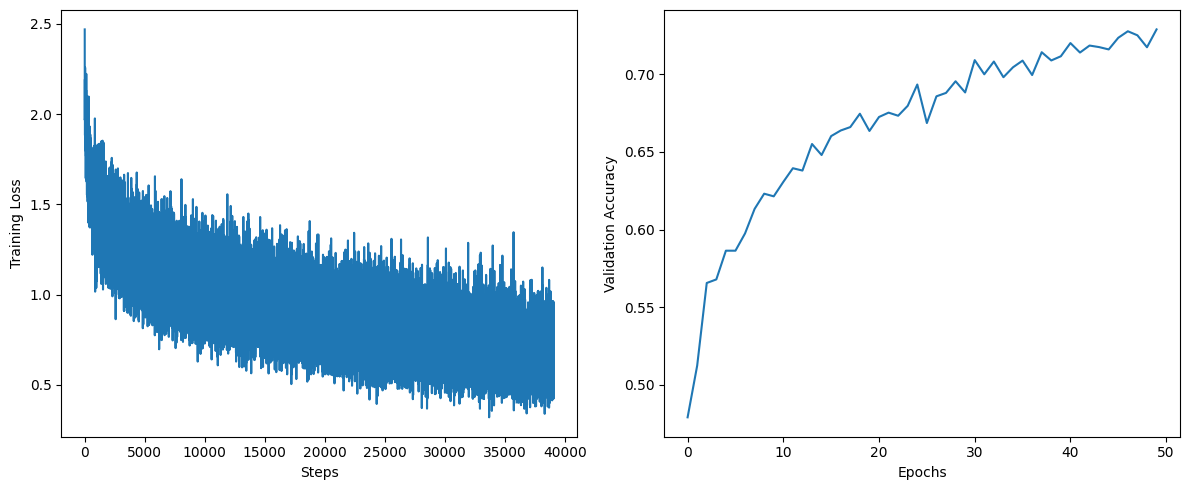

In [20]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATASET_CACHE_DIR = './data'
BATCH_SIZE = 64
LR = 3e-4
N_EPOCHS = 50

transforms_val = T.Compose([
    T.ToTensor(),
    T.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])
transforms_train = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    T.ToTensor(),
    T.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])

model = VisionTransformer().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

dataloader_train = DataLoader(CIFAR10(root=DATASET_CACHE_DIR, train=True, download=True, transform=transforms_train), batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4)
dataloader_val = DataLoader(CIFAR10(root=DATASET_CACHE_DIR, train=False, download=True, transform=transforms_val), batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4)

train_losses = []
val_accs = []

for i_epoch in range(N_EPOCHS):
    model.train()
    for i_step, (images, labels) in (pbar := tqdm(enumerate(dataloader_train), desc=f'Training (Epoch {i_epoch + 1}/{N_EPOCHS})')):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        loss_val = loss.detach().item()
        train_losses.append(loss_val)
        pbar.set_postfix({'loss': loss_val} | ({'val_acc': val_accs[-1]} if len(val_accs) > 0 else {}))

    model.eval()
    with torch.no_grad():
        n_total, n_correct = 0, 0
        for images, labels in tqdm(dataloader_val, desc='Validating'):
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            predicted = output.argmax(dim=-1)
            n_correct += (predicted == labels).sum().item()
            n_total += labels.shape[0]
        val_acc = n_correct / n_total
        val_accs.append(val_acc)
        print(f'Validation accuracy after epoch {i_epoch + 1}: {val_acc:.3f}')

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(train_losses)
plt.xlabel('Steps')
plt.ylabel('Training Loss')
plt.subplot(122)
plt.plot(val_accs)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.tight_layout()
plt.show()